In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["ZE_ENABLE_TRACING_LAYER"] = "1"

import torch
import torch.nn as nn

print(f"PyTorch Version: {torch.__version__}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch Version: 2.4.1+cu121
Using device: cuda


importar simple tokenizer.py, model.py

In [3]:
import sys
import os

# Obtém o caminho absoluto para o diretório 'src'
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adiciona o diretório 'src' ao sys.path
if src_path not in sys.path:
    sys.path.append(src_path)

# Agora você pode importar módulos de dentro de 'src' como se fosse um pacote de nível superior

In [4]:
import clip

In [5]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [6]:
import argparse
import numpy as np
import random

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--raf_path', type=str, default='../../data/raf-basic', help='raf_dataset_path')
parser.add_argument('--resnet50_path', type=str, default='../../data/resnet50_ft_weight.pkl', help='pretrained_backbone_path')
parser.add_argument('--label_path', type=str, default='list_patition_label.txt', help='label_path')
parser.add_argument('--workers', type=int, default=2, help='number of workers')
parser.add_argument('--batch_size', type=int, default=32, help='batch_size')
parser.add_argument('--w', type=int, default=7, help='width of the attention map')
parser.add_argument('--h', type=int, default=7, help='height of the attention map')
parser.add_argument('--gpu', type=int, default=0, help='the number of the device')
parser.add_argument('--lam', type=float, default=5, help='kl_lambda')
parser.add_argument('--epochs', type=int, default=60, help='number of epochs')
args = parser.parse_args(args=[])

### Arquitetura do Modelo

In [8]:
"""
import cafe.model
from cafe.model import Model
from AdaFuse.model import Model as Model
"""

'\nimport cafe.model\nfrom cafe.model import Model\nfrom AdaFuse.model import Model as Model\n'

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
from torch.nn.modules.utils import _single, _pair, _triple
from torch.nn.parameter import Parameter

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

class ResNet(nn.Module):
    def __init__(self, block, n_blocks, channels, output_dim):
        super().__init__()


        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block=BasicBlock, n_blocks=[2,2,2,2], channels=[64, 128, 256, 512], stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def Mask(nb_batch):
    bar = []
    for i in range(7):
        foo = [1] * 63 + [0] * 10
        if i == 6:
            foo = [1] * 64 + [0] * 10
        random.shuffle(foo)  # generate mask
        bar += foo
    bar = [bar for _ in range(nb_batch)]
    bar = np.array(bar).astype("float32")
    bar = bar.reshape(nb_batch, 512, 1, 1)
    bar = torch.from_numpy(bar)

    # Verifica se XPU está disponível
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bar = bar.to(device)
    bar = Variable(bar)
    return bar


###### channel separation and channel diverse loss
def supervisor(x, targets, cnum):
    branch = x
    branch = branch.reshape(branch.size(0),branch.size(1), 1, 1)
    branch = my_MaxPool2d(kernel_size=(1,cnum), stride=(1,cnum))(branch)
    branch = branch.reshape(branch.size(0),branch.size(1), branch.size(2) * branch.size(3))
    loss_2 = 1.0 - 1.0*torch.mean(torch.sum(branch,2))/cnum # set margin = 3.0

    mask = Mask(x.size(0))
    branch_1 = x.reshape(x.size(0),x.size(1), 1, 1) * mask
    branch_1 = my_MaxPool2d(kernel_size=(1,cnum), stride=(1,cnum))(branch_1)
    branch_1 = branch_1.view(branch_1.size(0), -1)
    loss_1 = nn.CrossEntropyLoss()(branch_1, targets)
    return [loss_1, loss_2]


class my_MaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, dilation=1,
                 return_indices=False, ceil_mode=False):
        super(my_MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride or kernel_size
        self.padding = padding
        self.dilation = dilation
        self.return_indices = return_indices
        self.ceil_mode = ceil_mode

    def forward(self, input):
        input = input.transpose(3,1)


        input = F.max_pool2d(input, self.kernel_size, self.stride,
                            self.padding, self.dilation, self.ceil_mode,
                            self.return_indices)
        input = input.transpose(3,1).contiguous()

        return input

    def __repr__(self):
        kh, kw = _pair(self.kernel_size)
        dh, dw = _pair(self.stride)
        padh, padw = _pair(self.padding)
        dilh, dilw = _pair(self.dilation)
        padding_str = ', padding=(' + str(padh) + ', ' + str(padw) + ')' \
            if padh != 0 or padw != 0 else ''
        dilation_str = (', dilation=(' + str(dilh) + ', ' + str(dilw) + ')'
                        if dilh != 0 and dilw != 0 else '')
        ceil_str = ', ceil_mode=' + str(self.ceil_mode)
        return self.__class__.__name__ + '(' \
            + 'kernel_size=(' + str(kh) + ', ' + str(kw) + ')' \
            + ', stride=(' + str(dh) + ', ' + str(dw) + ')' \
            + padding_str + dilation_str + ceil_str + ')'


class my_AvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, ceil_mode=False,
                 count_include_pad=True):
        super(my_AvgPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride or kernel_size
        self.padding = padding
        self.ceil_mode = ceil_mode
        self.count_include_pad = count_include_pad

    def forward(self, input):
        input = input.transpose(3,1)
        input = F.avg_pool2d(input, self.kernel_size, self.stride,
                            self.padding, self.ceil_mode, self.count_include_pad)
        input = input.transpose(3,1).contiguous()
        return input


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'kernel_size=' + str(self.kernel_size) \
            + ', stride=' + str(self.stride) \
            + ', padding=' + str(self.padding) \
            + ', ceil_mode=' + str(self.ceil_mode) \
            + ', count_include_pad=' + str(self.count_include_pad) + ')'

In [10]:
class Model(nn.Module):
    def __init__(self, pretrained=True, num_classes=7, drop_rate=0, model_path=None):
        super(Model, self).__init__()

        res18 = ResNet(block=BasicBlock, n_blocks=[2, 2, 2, 2], channels=[64, 128, 256, 512], output_dim=1000)
        msceleb_model = torch.load(model_path)
        state_dict = msceleb_model['state_dict']
        res18.load_state_dict(state_dict, strict=False)

        self.drop_rate = drop_rate
        self.features = nn.Sequential(*list(res18.children())[:-2])
        self.features2 = nn.Sequential(*list(res18.children())[-2:-1])

        fc_in_dim = list(res18.children())[-1].in_features  # original fc layer's input dimension (512)
        self.fc = nn.Linear(fc_in_dim, num_classes)         # new fc layer 512 -> num_classes

        self.parm = {}
        for name, parameters in self.fc.named_parameters():
            print(name, ':', parameters.size())
            self.parm[name] = parameters
            
        
        self.gamma = nn.Parameter(torch.Tensor(1))
        self.last_lam = 0
        self.alpha = 0
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.zeros_(self.gamma)

    def forward(self, x, clip_model, targets, phase='train'):
        with torch.no_grad():
            image_features = clip_model.encode_image(x)

        x = self.features(x)
        x = self.features2(x)
        x = x.view(x.size(0), -1)

        ecnn = x
        eclip = image_features
        
        # Garante que alpha está no domínio válido (>0)
        self.alpha = torch.exp(self.gamma)

        # Amostra lam ~ Beta(alpha, alpha)
        lam = torch.distributions.Beta(self.alpha, self.alpha).sample().to(x.device)
        
        self.last_lam = lam 

        # Adaptive fusion: zfused = eclip * lam + ecnn * (1 - lam)
        zfused = eclip * lam + ecnn * (1 - lam)

        if phase == 'train':
            MC_loss = supervisor(zfused, targets, cnum=73)

        out = self.fc(zfused)

        if phase == 'train':
            return out, MC_loss
        else:
            return out, out

### Treinamento E Teste Codigos

In [11]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [12]:
from tqdm import tqdm

def train(model, train_loader, optimizer, scheduler, device):
    running_loss = 0.0
    iter_cnt = 0
    correct_sum = 0

    model.to(device)
    model.train()
    
    alpha_log = []
    gamma_log = []
    lambda_log = []

    total_loss = []
    with tqdm(total=len(train_loader)) as pbar:
        for batch_i, (imgs1, labels) in enumerate(train_loader):
            imgs1 = imgs1.to(device)
            labels = labels.to(device)

            criterion = nn.CrossEntropyLoss(reduction='none')

            output, MC_loss = model(imgs1, clip_model, labels, phase='train')
            
            # Após o forward, se o modelo salvou `lam` como atributo:
            if hasattr(model, 'alpha') and hasattr(model, 'gamma') and hasattr(model, 'last_lam'):
                alpha_log.append(model.alpha.item())
                lambda_log.append(model.last_lam.item())
                gamma_log.append(model.gamma.item())

            loss1 = nn.CrossEntropyLoss()(output, labels)

            loss = loss1 + 5 * MC_loss[1] + 1.5 * MC_loss[0]

            optimizer.zero_grad()
            print("gamma antes:", model.gamma.item())
            loss.backward()
            optimizer.step()
            print("gamma depois:", model.gamma.item())


            iter_cnt += 1
            _, predicts = torch.max(output, 1)
            correct_num = torch.eq(predicts, labels).sum()
            correct_sum += correct_num
            running_loss += loss

            pbar.update(1)  # Update progress bar for each batch

    scheduler.step()
    running_loss = running_loss / iter_cnt
    acc = correct_sum.float() / float(train_loader.dataset.__len__())
    return acc, running_loss, alpha_log, lambda_log, gamma_log

setup_seed(3407)

In [13]:
def test(model, test_loader, device):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        iter_cnt = 0
        correct_sum = 0
        data_num = 0


        for batch_i, (imgs1, labels) in enumerate(test_loader):
            imgs1 = imgs1.to(device)
            labels = labels.to(device)


            outputs, _ = model(imgs1, clip_model, labels, phase='test')


            loss = nn.CrossEntropyLoss()(outputs, labels)

            iter_cnt += 1
            _, predicts = torch.max(outputs, 1)

            correct_num = torch.eq(predicts, labels).sum()
            correct_sum += correct_num

            running_loss += loss
            data_num += outputs.size(0)

        running_loss = running_loss / iter_cnt
        test_acc = correct_sum.float() / float(data_num)
        
    return test_acc, running_loss

In [14]:
def load_pretrained_weights(model, checkpoint):
    import collections
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    model_dict = model.state_dict()
    new_state_dict = collections.OrderedDict()
    matched_layers, discarded_layers = [], []
    for k, v in state_dict.items():
        # If the pretrained state_dict was saved as nn.DataParallel,
        # keys would contain "module.", which should be ignored.
        if k.startswith('module.'):
            k = k[7:]
        if k in model_dict and model_dict[k].size() == v.size():
            new_state_dict[k] = v
            matched_layers.append(k)
        else:
            discarded_layers.append(k)
    # new_state_dict.requires_grad = False
    model_dict.update(new_state_dict)

    model.load_state_dict(model_dict)
    print('load_weight', len(matched_layers))
    return model

In [15]:
# Caminho do modelo em relação ao diretório atual (onde está o notebook)
model_path = os.path.join(os.path.dirname(os.getcwd()), 'models', 'resnet18_msceleb.pth')

# Carregando o modelo
model = Model(model_path=model_path)
model.to(device)

weight : torch.Size([7, 512])
bias : torch.Size([7])


<ipython-input-10-5566f2206854>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  msceleb_model = torch.load(model_path)


Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [18]:
from torchvision import transforms

In [19]:
eval_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [20]:
train_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(scale=(0.02, 0.25))
    ])

### Caregamento de Dataset

In [21]:
import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class FERPlusDataset(Dataset):
    """
    Um PyTorch Dataset para o conjunto de dados FERPLUS.

    Args:
        root_dir (str): O diretório raiz onde os subdiretórios FER2013Test,
                        FER2013Train e FER2013Valid estão localizados.
        csv_file (str): O caminho completo para o arquivo 'fer2013new.csv'.
        idxs_fer (dict): Dicionário de mapeamento de índices FER+ para um formato intermediário.
                         Ex: {0: 0, 1: 1, ...}
        idxs_test (dict): Dicionário de mapeamento do formato intermediário para o rótulo final.
                         Ex: {0: 0, 1: 1, ...}
        subset (str): O subconjunto de dados a ser carregado ('train', 'valid' ou 'test').
        transform (callable, optional): Uma função/transformação a ser aplicada nas imagens.
    """
    def __init__(self, root_dir: str, csv_file: str, idxs_fer: dict, idxs_test: dict, subset: str, transform=None):
        if not isinstance(root_dir, str) or not os.path.isdir(root_dir):
            raise ValueError(f"O parâmetro 'root_dir' deve ser um caminho de diretório válido. '{root_dir}' não é um diretório.")
        
        if not isinstance(csv_file, str) or not os.path.exists(csv_file):
            raise ValueError(f"O parâmetro 'csv_file' deve ser um caminho de arquivo CSV válido. '{csv_file}' não é um arquivo ou não existe.")
            
        if subset not in ['train', 'valid', 'test']:
            raise ValueError("O parâmetro 'subset' deve ser 'train', 'valid' ou 'test'.")

        if not isinstance(idxs_fer, dict):
            raise TypeError("O parâmetro 'idxs_fer' deve ser um dicionário.")
        if not isinstance(idxs_test, dict):
            raise TypeError("O parâmetro 'idxs_test' deve ser um dicionário.")

        self.root_dir = root_dir
        self.csv_file = csv_file
        self.subset = subset
        self.transform = transform
        
        # Definir as colunas de emoção esperadas no CSV (do fer2013new.csv)
        self.raw_column_names = [
            'usage', 'Image name', 'neutral', 'happiness', 'surprise', 'sadness', 
            'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF'
        ]
        
        # As 7 emoções que você quer focar para o mapeamento
        self.emotion_cols = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']
        self.emotion_labels = self.emotion_cols # Usamos a mesma lista para mapeamento de índice

        self.idxs_fer = idxs_fer
        self.idxs_test = idxs_test

        self.data_frame = self._load_data()
        
        if self.__len__() == 0:
            raise RuntimeError(f"Nenhum dado válido encontrado para o subconjunto '{self.subset}' no arquivo CSV '{self.csv_file}'. Verifique o conteúdo e a estrutura do CSV e do diretório de imagens.")

    def _load_data(self):
        """
        Carrega o arquivo fer2013new.csv, prepara o DataFrame e processa os rótulos.
        Associa as imagens com base na coluna 'Image name' do CSV e filtra
        pelo 'usage' para o subset correto.
        """
        if not os.path.exists(self.csv_file):
            raise FileNotFoundError(f"O arquivo CSV não foi encontrado em: {self.csv_file}. Certifique-se de que o caminho está correto.")
        
        try:
            df_full = pd.read_csv(self.csv_file, header=0, names=self.raw_column_names) # header=0 pois tem cabeçalho
        except pd.errors.EmptyDataError:
            raise ValueError(f"O arquivo CSV '{self.csv_file}' está vazio.")
        except pd.errors.ParserError as e:
            raise ValueError(f"Erro ao analisar o arquivo CSV '{self.csv_file}'. Verifique a formatação do arquivo. Detalhe: {e}")
        except Exception as e:
            raise RuntimeError(f"Ocorreu um erro inesperado ao carregar o CSV '{self.csv_file}': {e}")

        # Verificar se todas as colunas esperadas estão presentes
        for col in self.raw_column_names:
            if col not in df_full.columns:
                raise RuntimeError(f"A coluna esperada '{col}' não foi encontrada no CSV '{self.csv_file}'. Verifique os nomes das colunas e o cabeçalho.")

        # Mapeamento do 'usage' do CSV para o nome da pasta
        usage_to_subset_map = {
            'Training': 'train',
            'PublicTest': 'valid', 
            'PrivateTest': 'test' 
        }

        # Filtrar o DataFrame pelo 'usage' correspondente ao subset
        csv_usage_name = None
        for usage_key, subset_val in usage_to_subset_map.items():
            if subset_val == self.subset:
                csv_usage_name = usage_key
                break
        
        if csv_usage_name is None:
            raise ValueError(f"Mapeamento interno de 'subset' para 'usage' no CSV está incorreto para '{self.subset}'.")

        df_subset = df_full[df_full['usage'] == csv_usage_name].copy()

        if df_subset.empty:
            return pd.DataFrame() # Retorna um DataFrame vazio se não houver dados

        subset_dir_map = {
            'train': 'FER2013Train',
            'valid': 'FER2013Valid',
            'test': 'FER2013Test'
        }
        image_folder = subset_dir_map[self.subset]
        
        # Assegurar que 'Image name' seja string e não tenha NaNs
        df_subset['Image name'] = df_subset['Image name'].fillna('').astype(str)
        
        # Filtrar linhas onde 'Image name' ficou vazio após fillna (indicando dados ausentes/inválidos)
        initial_image_name_count = len(df_subset)
        df_subset = df_subset[df_subset['Image name'] != '']
        if len(df_subset) < initial_image_name_count:
            pass # Removed print for clean output

        # Construir o caminho completo da imagem usando a coluna 'Image name'
        df_subset['image_path'] = df_subset['Image name'].apply(
            lambda img_name: os.path.join(self.root_dir, image_folder, img_name)
        )
        
        # Encontrar o rótulo com a maior contagem de votos para cada imagem
        def get_single_label(row):
            # Obtém as contagens de votos APENAS PARA AS EMOÇÕES DESEJADAS (as 7 principais)
            votes = row[self.emotion_cols].to_dict()
            
            if not votes: 
                return None
            
            numeric_votes = {k: pd.to_numeric(v, errors='coerce') for k, v in votes.items()}
            numeric_votes = {k: v for k, v in numeric_votes.items() if not pd.isna(v)}

            if not numeric_votes: 
                return None 
            
            # Use max(key=dict.get) para encontrar a chave com o valor máximo
            max_emotion = max(numeric_votes, key=numeric_votes.get)
            
            return max_emotion

        df_subset['single_label'] = df_subset.apply(get_single_label, axis=1)

        # Filtra linhas onde o caminho da imagem pode ser inválido
        initial_count = len(df_subset)
        df_subset = df_subset[df_subset['image_path'].apply(lambda x: os.path.exists(x))]
        if len(df_subset) < initial_count:
            pass # Removed print for clean output
            
        return df_subset

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if not (0 <= idx < len(self.data_frame)):
            raise IndexError(f"Índice {idx} fora dos limites do dataset (tamanho: {len(self.data_frame)}).")

        img_path = self.data_frame.iloc[idx]['image_path']
        label_str = self.data_frame.iloc[idx]['single_label']
        
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Imagem não encontrada em '{img_path}' para o índice {idx}. Por favor, verifique o arquivo.")
        except UnidentifiedImageError:
            raise UnidentifiedImageError(f"Não foi possível identificar o formato da imagem em '{img_path}' para o índice {idx}. Pode estar corrompida.")
        except Exception as e:
            raise RuntimeError(f"Erro inesperado ao carregar a imagem '{img_path}' para o índice {idx}: {e}")

        try:
            original_label_idx = self.emotion_labels.index(label_str)
        except ValueError:
            raise ValueError(f"Rótulo '{label_str}' para o índice {idx} não encontrado em 'emotion_labels'. Verifique a consistência dos dados.")
            
        try:
            # Apply the two-step mapping
            mapped_label_step1 = self.idxs_fer[original_label_idx]
            final_label = self.idxs_test[mapped_label_step1]
            label = torch.tensor(final_label).long()
        except KeyError as e:
            raise KeyError(f"Mapeamento de rótulo falhou para '{label_str}' (índice original: {original_label_idx}) no índice {idx}. Chave não encontrada no dicionário de mapeamento: {e.args[0]}.")
        except Exception as e:
            raise RuntimeError(f"Erro inesperado no mapeamento de rótulos para '{label_str}' no índice {idx}: {e}.")

        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                raise RuntimeError(f"Erro ao aplicar transformação na imagem '{img_path}' para o índice {idx}: {e}.")
            
        return image, label

In [22]:
emotion_to_index = {
            "neutral": 0,
            "happiness": 1,
            "surprise": 2,
            "sadness": 3,
            "angry": 4,
            "disgust": 5,
            "fear": 6,
        }

index_to_emotion = {v: k for k, v in emotion_to_index.items()}

In [23]:
path = '/workspace/sergiojunior/FERPlus/data'
csv = '/workspace/sergiojunior/FERPlus/fer2013new.csv'

In [24]:
# 2. Criar instâncias do Dataset
try:
    train_dataset = FERPlusDataset(path, csv, idxs_fer=index_to_emotion, idxs_test=emotion_to_index, subset='train', transform=train_transforms)
    val_dataset = FERPlusDataset(path, csv, idxs_fer=index_to_emotion, idxs_test=emotion_to_index, subset='valid', transform=eval_transforms)

    # 3. Criar DataLoaders (para iterar em batches)
    from torch.utils.data import DataLoader

    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # num_workers > 0 para paralelismo
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print("\nTestando o DataLoader de treino:")
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Batch {batch_idx}:")
        print(f"  Shape das Imagens: {images.shape}") # Ex: torch.Size([4, 3, 224, 224]) (batch_size, channels, height, width)
        print(f"  Shape dos Labels: {labels.shape}")   # Ex: torch.Size([4])
        print(f"  Labels: {labels}")
        if batch_idx == 0: # Apenas para o primeiro batch
            break

    print("\nTestando o DataLoader de validação:")
    for batch_idx, (images, labels) in enumerate(val_loader):
        print(f"Batch {batch_idx}:")
        print(f"  Shape das Imagens: {images.shape}")
        print(f"  Shape dos Labels: {labels.shape}")
        print(f"  Labels: {labels}")
        if batch_idx == 0:
            break

except FileNotFoundError as e:
    print(f"Erro: {e}. Certifique-se de que o caminho para o AffectNet está correto e a estrutura de diretórios está como esperado.")
except ValueError as e:
    print(f"Erro ao inicializar o dataset: {e}")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Testando o DataLoader de treino:
Batch 0:
  Shape das Imagens: torch.Size([4, 3, 224, 224])
  Shape dos Labels: torch.Size([4])
  Labels: tensor([0, 2, 1, 2])

Testando o DataLoader de validação:
Batch 0:
  Shape das Imagens: torch.Size([4, 3, 224, 224])
  Shape dos Labels: torch.Size([4])
  Labels: tensor([0, 5, 0, 0])


In [25]:
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           #batch_size=1,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)

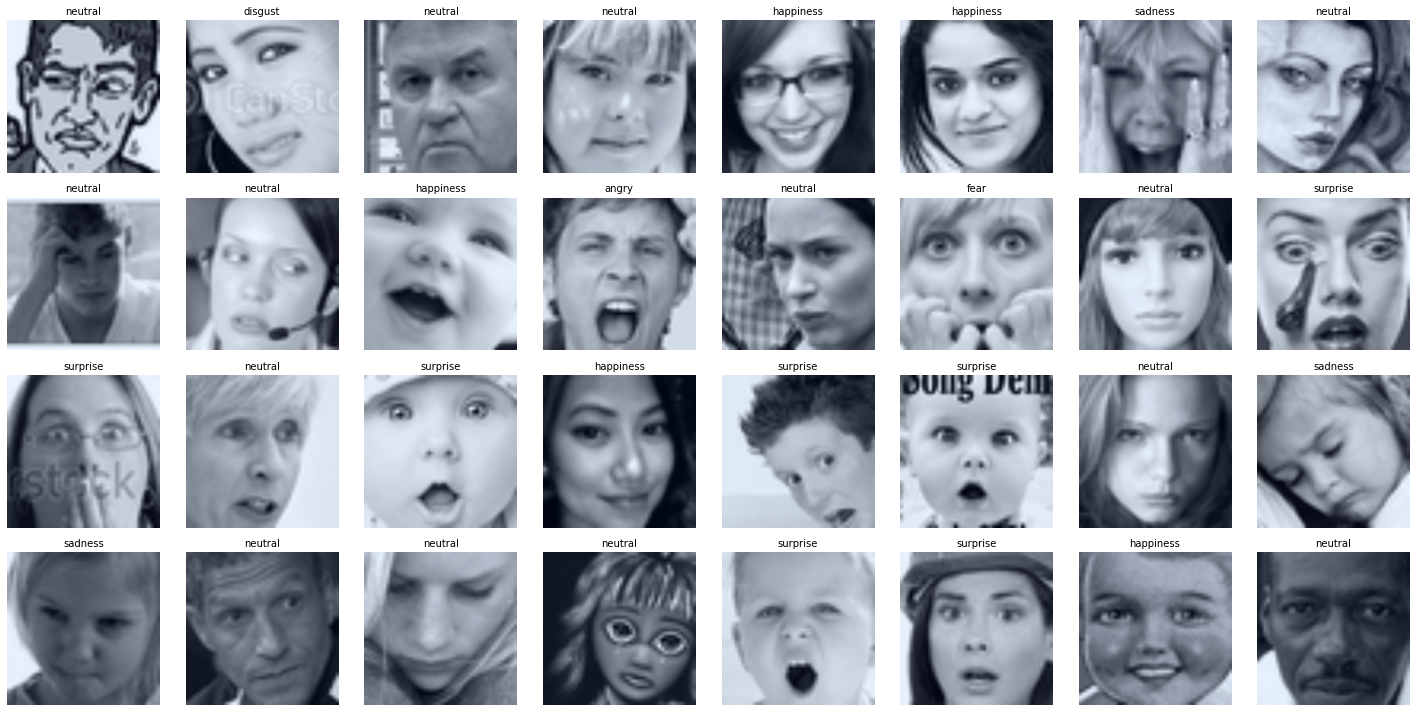

In [27]:
import matplotlib.pyplot as plt
from PIL import Image


# Obtendo o batch de imagens e rótulos
for images, labels in test_loader:
    # Se você quiser mostrar apenas um batch
    break

# Definindo o layout para 4 linhas e 8 colunas
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4x8 layout
axes = axes.flatten()  # Flatten para facilitar a iteração

# Loop para exibir as imagens no grid
for i, (img, label) in enumerate(zip(images, labels)):
    if i >= len(axes):  # Se houver mais imagens do que subgráficos
        break

    # Convertendo a imagem para numpy e normalizando
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Exibindo a imagem
    ax = axes[i]
    ax.imshow(img_np)
    ax.axis('off')  # Desativar os eixos

    # Usando o mapa de rótulos para mostrar o nome da emoção
    label_name = index_to_emotion[label.item()]
    ax.set_title(f"{label_name}", fontsize=10)  # Título com o nome do label

# Ajustar o layout para não sobrepor as imagens
plt.tight_layout()
plt.show()

In [28]:
import torch.nn as nn

In [29]:
save_path = os.path.join(os.path.dirname(os.getcwd()), 'models/AdaFuse_v2')
# os.makedirs() com exist_ok=True é a forma mais concisa
os.makedirs(save_path, exist_ok=True)
print(f"Diretório '{save_path}' garantido (criado se não existia).")

Diretório '/home/sergiojunior/FER-generalizavel/models/AdaFuse_v2' garantido (criado se não existia).


In [30]:
device

device(type='cuda')

In [31]:
all_alpha_logs = []
all_lambda_logs = []
all_gamma_logs = []

In [33]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

gamma
features.0.weight
features.1.weight
features.1.bias
features.4.0.conv1.weight
features.4.0.bn1.weight
features.4.0.bn1.bias
features.4.0.conv2.weight
features.4.0.bn2.weight
features.4.0.bn2.bias
features.4.1.conv1.weight
features.4.1.bn1.weight
features.4.1.bn1.bias
features.4.1.conv2.weight
features.4.1.bn2.weight
features.4.1.bn2.bias
features.5.0.conv1.weight
features.5.0.bn1.weight
features.5.0.bn1.bias
features.5.0.conv2.weight
features.5.0.bn2.weight
features.5.0.bn2.bias
features.5.0.downsample.0.weight
features.5.0.downsample.1.weight
features.5.0.downsample.1.bias
features.5.1.conv1.weight
features.5.1.bn1.weight
features.5.1.bn1.bias
features.5.1.conv2.weight
features.5.1.bn2.weight
features.5.1.bn2.bias
features.6.0.conv1.weight
features.6.0.bn1.weight
features.6.0.bn1.bias
features.6.0.conv2.weight
features.6.0.bn2.weight
features.6.0.bn2.bias
features.6.0.downsample.0.weight
features.6.0.downsample.1.weight
features.6.0.downsample.1.bias
features.6.1.conv1.weight
fe

In [32]:
best_acc = 0
patience = 100  # Number of epochs to wait for improvement
no_improvement = 0

for i in range(1, args.epochs + 1):
    train_acc, train_loss, alpha_log, lambda_log, gamma_log  = train(model, train_loader, optimizer, scheduler, device)
    test_acc, test_loss = test(model, test_loader, device)

    print('epoch:', i,
          '| acc_test:', test_acc.item(),
          '| acc_train:', train_acc.item(),
          '| gamma (últ):', gamma_log[-1] if gamma_log else None,
          '| alpha (últ):', alpha_log[-1] if alpha_log else None,
          '| lam (últ):', lambda_log[-1] if lambda_log else None)
    
    all_alpha_logs.extend(alpha_log)
    all_lambda_logs.extend(lambda_log)
    all_gamma_logs.extend(gamma_log)


    # Early stopping logic with patience
    if test_acc > best_acc:
        best_acc = test_acc
        no_improvement = 0  # Reset patience counter on improvement
        torch.save({'model_state_dict': model.state_dict(),}, f"{save_path}/ours_best_FERPLUS.pth")
    else:
        no_improvement += 1  # Increment patience counter on no improvement

  0%|          | 1/893 [00:00<09:52,  1.51it/s]

gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  0%|          | 3/893 [00:00<03:21,  4.41it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  1%|          | 7/893 [00:01<01:37,  9.10it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0


  1%|          | 11/893 [00:01<01:11, 12.33it/s]

gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  2%|▏         | 15/893 [00:01<01:01, 14.25it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0


  2%|▏         | 17/893 [00:01<00:58, 14.88it/s]

gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  2%|▏         | 21/893 [00:01<00:56, 15.31it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0


  3%|▎         | 25/893 [00:02<00:55, 15.71it/s]

gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  3%|▎         | 29/893 [00:02<00:53, 16.05it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0


  3%|▎         | 31/893 [00:02<00:53, 16.13it/s]

gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  4%|▍         | 35/893 [00:02<00:53, 16.02it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0


  4%|▍         | 39/893 [00:03<00:52, 16.16it/s]

gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  5%|▍         | 43/893 [00:03<00:52, 16.14it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0


  5%|▌         | 45/893 [00:03<00:52, 16.20it/s]

gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  5%|▌         | 49/893 [00:03<00:51, 16.32it/s]

gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0
gamma depois: 0.0
gamma antes: 0.0


  5%|▌         | 49/893 [00:03<01:04, 13.05it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_alpha_logs, label='alpha')
plt.plot(all_lambda_logs, label='lambda')
plt.legend()
plt.title("Evolução de alpha e lambda durante o treinamento")
plt.xlabel("Iterações")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

# Teste cruzado

### Download de datasets

In [ ]:
import kagglehub

# Download latest version
path_rafdb = kagglehub.dataset_download("shuvoalok/raf-db-dataset")

print("Path to dataset files:", path_rafdb)

In [ ]:
import kagglehub

# Download latest version
path_mma = kagglehub.dataset_download("mahmoudima/mma-facial-expression")
path_mma = path_mma + '/MMAFEDB'
print("Path to dataset files:", path_mma)

In [ ]:
affectnet_root = '/workspace/sergiojunior/AffectNet-8Labels'

### Teste entre dominios

In [ ]:
from aux.emotion_idx import *
from emotion_datasets import MMADataset, RafDataSet, SFEWDataset, AffectNetDataset

In [ ]:
"""
dataset_sfew = SFEWDataset(root_dir=path_sfew, idx_test=emotion_to_index_raf, idx_sfew=index_to_emotion_sfew, split="Val", transform=eval_transforms)
loader_sfew = torch.utils.data.DataLoader(dataset_sfew, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)
"""

dataset_mma = MMADataset(root_dir=path_mma, idx_test=emotion_to_index_fer, idx_mma=index_to_emotion_mma, split="test", transform=eval_transforms)
loader_mma = torch.utils.data.DataLoader(dataset_mma, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

dataset_affect = AffectNetDataset(root_dir=affectnet_root, idxs_test=emotion_to_index_fer, idxs_aff=index_to_emotion_aff, subset='val', transform=eval_transforms)
loader_affect = torch.utils.data.DataLoader(dataset_affect, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

dataset_raf = RafDataSet(path_rafdb, idxs_test=emotion_to_index_fer, idxs_raf=index_to_emotion_raf, train=False, transform=eval_transforms)
loader_raf = torch.utils.data.DataLoader(dataset_raf,
                                           batch_size=args.batch_size,
                                           shuffle=False,
                                           num_workers=args.workers,
                                           pin_memory=True)

dataset_fer = FERPlusDataset(path, csv, idxs_test=emotion_to_index_fer, idxs_fer=index_to_emotion_fer, subset='valid', transform=eval_transforms)
loader_fer = torch.utils.data.DataLoader(dataset_fer, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)

In [ ]:
checkpoint = torch.load(f"{save_path}/ours_best_FERPLUS.pth")
checkpoint = checkpoint["model_state_dict"]
model = load_pretrained_weights(model, checkpoint)
model.to(device)

In [ ]:
###### FER
acc_raf_fer, test_loss = test(model, loader_fer, device)
print('test acc dbtrain-raf dbtest-fer: ', acc_raf_fer)

### RAFDB
acc_raf_raf, test_loss = test(model, loader_raf, device)
print('test acc dbtrain-raf dbtest-raf: ', acc_raf_raf)

###### AFFECT
acc_raf_affect, test_loss = test(model, loader_affect, device)
print('test acc dbtrain-raf dbtest-affect: ', acc_raf_affect)

###### MMA
acc_raf_mma, test_loss = test(model, loader_mma, device)
print('test acc dbtrain-raf dbtest-mma: ', acc_raf_mma)

In [ ]:
###### SFEW
acc_raf_sfew, test_loss = test(model, loader_sfew, device)
print('test acc dbtrain-raf dbtest-sfew: ', acc_raf_sfew)